## Задача

Необходимо разработать алгоритм, который для каждой строчки (товара) датасета `validation.csv` подберет 5 наиболее подходящих строчек (товаров) из датасета `base.csv`. Для тренировки и отладки алгоритма прилагается датасет `train.csv`. 

## Метрика проекта

Метрика проекта - `accuracy@5`, которая для каждого объекта датасета, в котором осуществляется поиск, подбирает 5 наиболее близких объектов.
Формула для одного объекта:
$$
accuracy@5 = 100 * \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}} {5}
$$

Значение метрики для датасета равно среднему значению метрики `accuracy@5` для каждого объекта датасета.

## Данные

<ins>Источник</ins>: https://disk.yandex.ru/d/BBEphK0EHSJ5Jw

<ins>Список датасетов</ins>:

1. `base.csv` : база данных всех товаров.
    - Насчитывает 72 признака и 2918139 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
2. `train.csv` : обучающая выборка, взятая из `base.csv`.
    - Насчитывает 73 признака и 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
    - Признаки включают столбец с размеченными экспертами идентификаторами похожих товаров из `base.csv`
3. `validatation.csv` : база данных товаров, взятых из `base.csv`, для которых необходимо найти похожие.
    - Насчитывает 72 признака и 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
4. `validation_answer.csv` : база данных, с разметкой похожих для товаров из `validatation.csv`.
    - Насчитывает 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.

## Загрузка библиотек

In [1]:
# библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from tqdm import tqdm
from tqdm.notebook import trange
from tqdm.contrib.itertools import product

import faiss

## Загрузка и проверка данных из файлов.

### Загрузка

<ins>base.csv</ins>:

In [2]:
%%time

df_base = pd.read_csv('./datasets/base.csv', nrows=3_000_000, index_col=0)
df_base.head()

Wall time: 29.6 s


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


<ins>train.csv</ins>:

In [3]:
%%time

df_train = pd.read_csv('./datasets/train.csv', index_col=0)
df_train.head()

Wall time: 1.54 s


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


<ins>validation.csv</ins>:

In [4]:
%%time

df_validation = pd.read_csv('./datasets/validation.csv', index_col=0)
df_validation.head()

Wall time: 1.07 s


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


<ins>validation_answer</ins>

In [5]:
%%time

df_valid_answ = pd.read_csv('./datasets/validation_answer.csv', index_col=0)
df_valid_answ.head()

Wall time: 160 ms


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


### Проверка данных методом .info()

In [6]:
%%time

# списки с загруженными датасетами и их названиями
df_list = [df_base, df_train, df_validation, df_valid_answ]
df_names = ['Базовый датасет', 'Обучающий датасет', 'Тестовый датасет', 'Ответы к тестовому датасету']

for df in zip(df_list, df_names):
    print(f'\nДанные по датасету "{df[1]}":\n')
    df[0].info()


Данные по датасету "Базовый датасет":

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 3

### Промежуточный вывод:

- Данные загрузились;
- Все признаки кроме ID - количественные, признак ID (уникальный идентификтаор объекта) - object;

## Предобработка

### Проверка данных на дубли.

In [7]:
%%time

for df in zip(df_list, df_names):
    print(f'\nЯвные дубли в датасете "{df[1]}":\n' +
          f'{df[0].duplicated().sum()}'
         )


Явные дубли в датасете "Базовый датасет":
0

Явные дубли в датасете "Обучающий датасет":
0

Явные дубли в датасете "Тестовый датасет":
0

Явные дубли в датасете "Ответы к тестовому датасету":
8498
Wall time: 57.7 s


### Проверка на пропуски в столбцах:

In [8]:
%%time

for df in zip(df_list, df_names):
    # внутри двойной сумматор. Если пропуски хотя бы где-то есть, можно исследовать детальнее.
    print(f'\nПропуски в датасете "{df[1]}":\n' +
          f'{df[0].isna().sum().sum()}'
         )


Пропуски в датасете "Базовый датасет":
0

Пропуски в датасете "Обучающий датасет":
0

Пропуски в датасете "Тестовый датасет":
0

Пропуски в датасете "Ответы к тестовому датасету":
0
Wall time: 2.14 s


### Промежуточный вывод:

В рассматриваемых датасетах:
- явных дублей нет, дубли в `df_valid_answ` допустимы, т.к. у нескольких объектов может быть один и тот же ответ;
- пропусков в столбцах нет;

## EDA:

- Т.к. все датасеты являются подвыборками `df_base`, то дальнейшее EDA будет проводиться только на базе него.
- Можно было бы ограничиться подвыборкой для исследования, но в целом графики строятся достаточно быстро на всем объеме данных.

### Гистограммы и boxplots признаков:

72it [00:15,  4.50it/s]


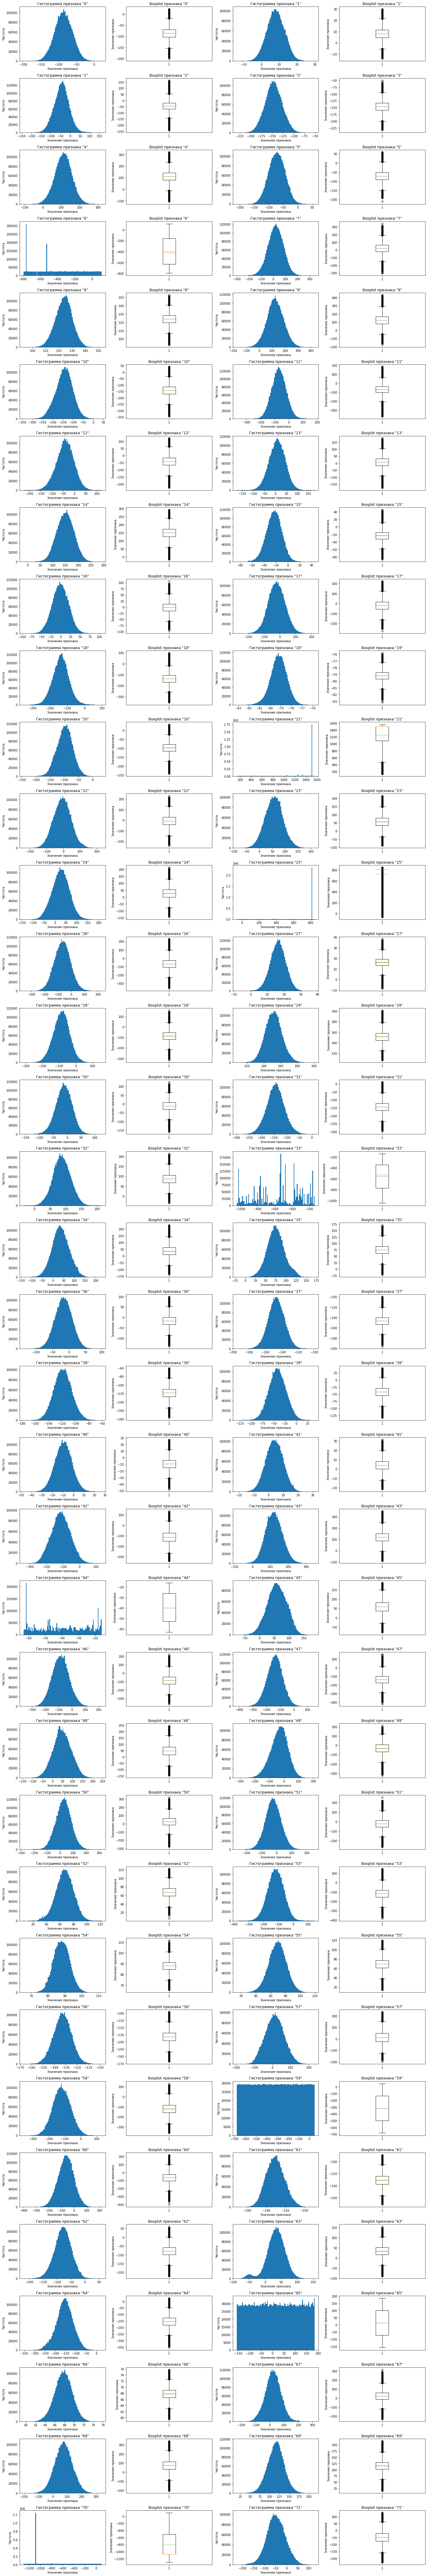

Wall time: 43.3 s


In [9]:
%%time

# считаем число строк для графиокв
cols_numeric = df_base.select_dtypes(exclude='object').columns
ncols = 4
nrows = cols_numeric.shape[0]
if nrows % ncols == 0:
    nrows = 2 * nrows // ncols
else:
    nrows = 2 * nrows // ncols + 1

# отрисовываем графики
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,120))

for i, col in tqdm(enumerate(cols_numeric)):
    # отрисовка гистограмм
    axs.flatten()[2*i].hist(x=df_base.loc[:, col], bins=100)
    axs.flatten()[2*i].set(title= f'Гистограмма признака "{col}"',
                         xlabel='Значение признака',
                         ylabel='Частота')
    # отрисковка boxplots рядом с гистограммами
    axs.flatten()[2*i+1].boxplot(df_base.loc[:, col], 
                                 meanline=True,
                                 showmeans=True)
    axs.flatten()[2*i+1].set(title= f'Boxplot признака "{col}"',
                             ylabel='Значение признака')
    
plt.tight_layout()
plt.show()

### Доля выбросов в данных

In [10]:
%%time

whisc_coef = 1.5

for col in cols_numeric:
    q3 = df_base[col].quantile(0.75)
    q1 = df_base[col].quantile(0.25)
    iqr = df_base[col].quantile(0.75) - df_base[col].quantile(0.25)

    lb = q1 - whisc_coef * iqr
    ub = q3 + whisc_coef * iqr

    idxs = (df_base[col] < lb) | (df_base[col] > ub)
    
    print(f'Процент выбросов в признаке "{col}" = ' +
          f'{df_base.loc[idxs, col].count() / df_base.shape[0]:.2%}'
         )

Процент выбросов в признаке "0" = 0.57%
Процент выбросов в признаке "1" = 0.59%
Процент выбросов в признаке "2" = 1.27%
Процент выбросов в признаке "3" = 0.67%
Процент выбросов в признаке "4" = 0.78%
Процент выбросов в признаке "5" = 0.48%
Процент выбросов в признаке "6" = 0.00%
Процент выбросов в признаке "7" = 0.89%
Процент выбросов в признаке "8" = 0.76%
Процент выбросов в признаке "9" = 0.83%
Процент выбросов в признаке "10" = 0.74%
Процент выбросов в признаке "11" = 0.84%
Процент выбросов в признаке "12" = 0.86%
Процент выбросов в признаке "13" = 0.71%
Процент выбросов в признаке "14" = 0.58%
Процент выбросов в признаке "15" = 0.98%
Процент выбросов в признаке "16" = 0.51%
Процент выбросов в признаке "17" = 0.65%
Процент выбросов в признаке "18" = 1.43%
Процент выбросов в признаке "19" = 1.09%
Процент выбросов в признаке "20" = 0.86%
Процент выбросов в признаке "21" = 8.29%
Процент выбросов в признаке "22" = 0.59%
Процент выбросов в признаке "23" = 0.68%
Процент выбросов в признак

### Корреляция

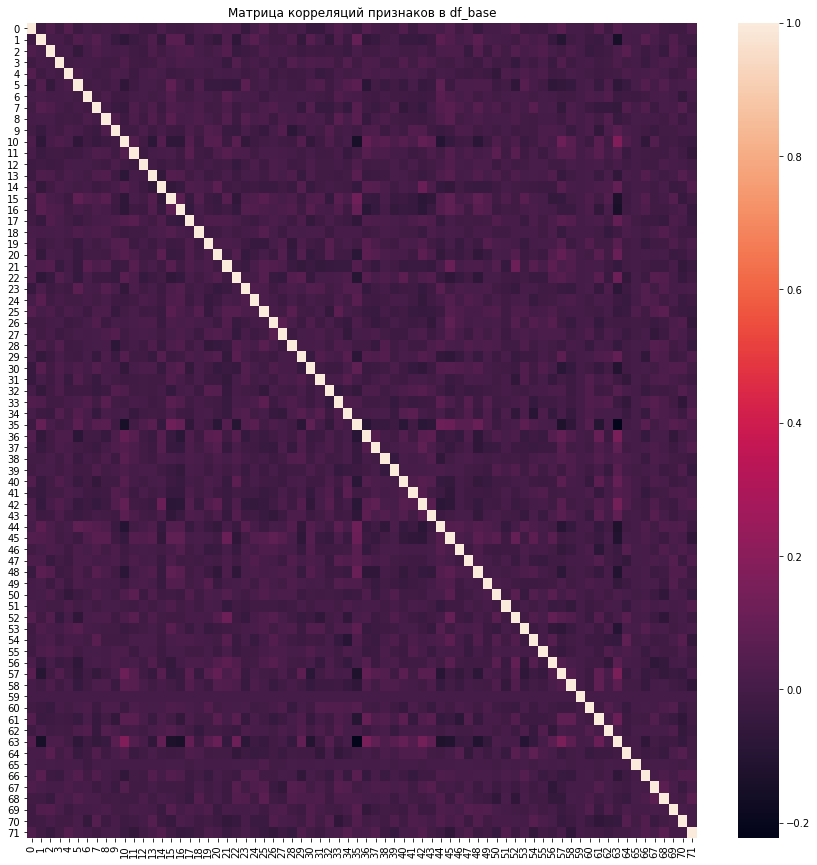

Wall time: 1min 2s


In [11]:
%%time

fig = plt.figure(figsize=(15,15))

ax = sns.heatmap(df_base[cols_numeric].corr(),
                 xticklabels=True, 
                 yticklabels=True)
ax.set_title('Матрица корреляций признаков в df_base')
plt.show()

### Общий вывод по разделу

- Все данные загружены без ошибок;
- Все признаки количественные;
- Явных дублей и пропусков в данных нет;
- Изучены распределения и boxplots признаков:
  - Признаки имеют различный масштаб.
  - Признаки "6", "21", "25", "33", "44", "59", "65", "70" имеют ненормальное распределение;
  - Признак "63" имеет второй невысокий пик в районе -50;
  - Почти у всех признаков с номарльным распределением процент выбросов не превышает 1.5% кроме признака "63", у которого доля выбросов на уровне 3.41% (если определять выбросы по усам boxplot);
  - Корреляция признаов отсутствует;

## Разработка алгоритма

Т.к. при работе над проектом возниклик сложности с документацией `FAISS`, я решил сконцентрироваться на проверке различных индексов библиотеки. При этом взять часть результатов из `baseline`, чтобы не тратить время на проверку того, что точно улучшает метрику, а именно:
- ненормально распределенные признаки "6", "21", "25", "33", "44", "59", "65", "70" ухудшают метрику, поэтому их следует убирать;
- стандартизация методом RobastScaler улучшает метрику;

На базе этого я проверю следующие моменты:
- признак 63 имеет небольшой пик на в районе -50, а также более высокий процент выбросов. Попробую его удалить и проверить метрику;
- проанализирую влияние различных индексов `FAISS` на метрику accuracy@5, начиная с самого базового индекса из документации `IndexFLATL2`.

В `baseline` значение метрики на тесте заифксировано на уровне 70.4%. Попробуем хоть немного ее улучшить методами библиотеки `FAISS`.

### Определим датасеты, на которых будем обучать и тестировать алгоритм:

In [12]:
# датасет для обучения
target_train = df_train['Target']
df_train = df_train.drop(['Target'], axis=1)

In [13]:
# признаки, которые удалили
feat_to_del = ['6', '21', '25', '33', '44', '59', '65', '70']

In [14]:
# датасеты, полученные путем удаления признаков
df_train_t = df_train.drop(columns=feat_to_del, axis=1)
df_base_t = df_base.drop(columns=feat_to_del, axis=1)
df_validation_t = df_validation.drop(columns=feat_to_del, axis=1)

Для проверки работы алгоритма будем брать только 10% данных. Итоговый алгоритм запустим на всех.

In [15]:
df = df_base_t.sample(frac=0.1, random_state=12345)

Станадртизация данных.

In [16]:
%%time

# стандартизация с помощью RobustScaler
RobScaler = RobustScaler().fit(df)
df_rs = pd.DataFrame(RobScaler.transform(df), 
                     index=df.index, 
                     columns=df.columns)

df_train_t_rs = pd.DataFrame(RobScaler.transform(df_train_t), 
                                                 index=df_train_t.index, 
                                                 columns=df_train_t.columns)

Wall time: 878 ms


Переведем `df_rs` и `df_train_t_rs` в в соответстие `FAISS` методом ascontiguousarray.

In [17]:
# переведем часть base и train в ascontiguousarray
df_arr = np.ascontiguousarray(df_rs.values).astype('float32')
df_eval_arr = np.ascontiguousarray(df_train_t_rs.values).astype('float32')

In [18]:
base_index = {k: v for k, v in enumerate(df_rs.index.to_list())}

Функция для вычисления метрики `accuracy@5`

In [20]:
def acc5_value(target, search_result, base_index):
    acc_faiss = 0
    for t, el in zip(target.values.tolist(), search_result):
        acc_faiss += int(t in [base_index[r] for r in el])
    result = 100 * acc_faiss / len(search_result)
    return result

### Базовый сценарий - IndexFlatL2

#### Инициализация и обучение

У этого индекса доступны параметры:
- dim - размерность вектора

In [25]:
# размерность
dim = df_arr.shape[1]
# инициализация индекса
index = faiss.IndexFlatL2(dim)
# индекс не нужно обучать
index.is_trained

True

Добавим векторов в индекс

In [26]:
%%time

index.add(df_arr)

Wall time: 71.2 ms


Осуществим поиск векторов из df_train методом К-ближайших соседей, где К=5

In [27]:
%%time

_, I = index.search(df_eval_arr, k=5)

Wall time: 1min 5s


Вычислим метрику `accuracy@5`

In [28]:
%%time

print(f'{round(acc5_value(target_train, I, base_index), 3)}%')

7.866%
Wall time: 379 ms


#### Вывод

- IndexFlatL2` не требует обучения, поэтому время на иницализацию и добавление векторов в индекс заняло 71 мс;
- Время поиска векторов в базе заняло 1 минуту и 5 секунд;
- Точность по заданной метрике равна 7.866% с учетом того, что база состоит из 10% датасета base;

### IndexFlatL2 + Удаление признака "63"

Проделаем всето же самое, но из исходного датасета уберем признак "63" и оценим метрику - станет она лучше или хуже.

#### Инициализация и обучение

In [32]:
# размерность на 1 признак меньше
dim = df_arr.shape[1] - 1
# инициализация индекса
index = faiss.IndexFlatL2(dim)
# индекс не нужно обучать
index.is_trained

True

Добавим вектора в индекс

In [33]:
%%time

# преобразование датасета под FAISS
df_arr_wo_63 = np.ascontiguousarray(df_rs.drop(columns=['63']).values).astype('float32')
# добавление векторов в индекс
index.add(df_arr_wo_63)

Wall time: 240 ms


Осуществим поиск индксов из df_train методом К-ближайших соседей, где К=5

In [34]:
%%time

df_eval_arr_wo_63 = np.ascontiguousarray(df_train_t_rs.drop(columns=['63']).values).astype('float32')
_, I = index.search(df_eval_arr_wo_63, k=5)

Wall time: 1min


Вычислим метрику `accuracy@5`

In [35]:
%%time

print(f'{round(acc5_value(target_train, I, base_index), 3)}%')

7.864%
Wall time: 382 ms


#### Вывод

- Время на иницализацию и добавление векторов в индекс заняло 240 мс;
- Время поиска векторов в базе заняло 1 минуту;
- Точность по заданной метрике равна 7.864% с учетом того, что база состоит из 10% датасета base;
- Значение метрики ухудшилось с 7.866% до 7.864%, значит признак стоит оставить;

Далее поработаем с перебором различных вариантов индексов и метрик в `FAISS`.

### IndexFlat с различными типами метрик

#### Инициализация и обучение

Обучим алгоритм на других метриках и посчитаем оценки:

In [51]:
%%time

# размерность
dim = df_rs.shape[1]
# метрика L2 (эвклидова метрика) считается для удобства дальнейшего сравнения
# рассматриваемые метрики
metrics = [faiss.METRIC_L2,faiss.METRIC_INNER_PRODUCT, faiss.METRIC_L1, faiss.METRIC_Linf, faiss.METRIC_Canberra, 
           faiss.METRIC_BrayCurtis, faiss.METRIC_Jaccard]
# названия метрик
metric_names = ['METRIC_L2','METRIC_INNER_PRODUCT', 'METRIC_L1', 'METRIC_Linf', 'METRIC_Canberra', 
                'METRIC_BrayCurtis', 'METRIC_Jaccard']

# инициализация индекса в цикле, обучение, поиск и расчет метркии:
train_time = 0
search_time = 0

result_acc_5 = {}
for metric, name in tqdm(list(zip(metrics, metric_names))):
    # время обучения старт
    start_faiss = perf_counter()
    # инициализация индекса
    index_test = faiss.IndexFlat(dim, metric)
    # добавление векторов в индекс
    index_test.add(df_arr)
    # время обучения конец
    train_time = perf_counter() - start_faiss
    # поиск в train
    # время поиска старт
    start_faiss = perf_counter()
    _, I = index_test.search(df_eval_arr, k=5)
    # время поиска конец
    search_time = perf_counter() - start_faiss
    # расчет метрики
    result_acc_5[name] = {'Метрика  acc@5, %': acc5_value(target_train, I, base_index),
                          'Время обучения, сек': train_time,
                          'Время поиска, сек': search_time,
                         }
    
# резульат запишем в датафрейм

results_metrics = pd.DataFrame(result_acc_5).T

100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [1:34:45<00:00, 812.24s/it]

Wall time: 1h 34min 45s


Результаты обучения и поиска для различных метрик:

In [53]:
results_metrics.style.format(precision=3)

,"Метрика acc@5, %","Время обучения, сек","Время поиска, сек"
METRIC_L2,7.866,0.057,59.759
METRIC_INNER_PRODUCT,7.619,0.033,43.360
METRIC_L1,7.834,0.033,332.942
METRIC_Linf,7.450,0.037,1346.998
METRIC_Canberra,7.604,0.033,489.758
METRIC_BrayCurtis,7.835,0.032,393.824
METRIC_Jaccard,5.041,0.026,3016.015


#### Вывод

Как видно из результатов выше, ни одна из метрик не смогла превзойти L2 (эвклидову). При этом она лучшая не только по качеству, но и по времени обучения и поиска вектора. Поэтому в дальнейшем будем работать именно с ней. 

Рассмотрим различные варианты индексов в `FAISS`.

### Различные варианты индексов `FAISS`

#### Вводная часть

Список базовых индексов, которые можно создать и обучить в `FAISS`, по инструкции (<href>https://github.com/facebookresearch/faiss/wiki/Faiss-indexes</href>) следующий:

<ins>были реализованы выше</ins>
- IndexFlatL2 (реализован выше с `METRIC_L2`);
- IndexFlatIP (реализован выше с `METRIC_INNER_PRODUCT`);

<ins>еще не были реализованы</ins>
- IndexHNSWFlat;
- IndexIVFFlat;
- IndexLSH;
- IndexScalarQuantizer;
- IndexPQ
- IndexIVFScalarQuantizer;
- IndexIVFPQ;

Попробуем последовательно реализовывать их с несколькими наборами параметров. Во всех реализациях ниже будет использоваться метрика `L2`.

#### Индекс IndexHNSWFlat

Начнем с `IndexHNSWFlat`. У этого индекса доступны параметры:
- dim - размерность вектора
- M - число соединений, которые будут созданы для каждой новой вершины при построении HNSW графа.

##### Инициализация и оубчение

In [56]:
# параметры
# Размерность 
dim = df_arr.shape[1]
# M
M = [50, 100, 300, 500, 1000, 2000]

# сюда будем добавлять результаты
result_acc_5 = []

for m in tqdm(M):
    # время обучения старт
    start_faiss = perf_counter()
    # инициализация индекса
    indHNSWF = faiss.IndexHNSWFlat(dim, m, faiss.METRIC_L2)
    # обучение
    indHNSWF.train(df_arr)
    # добавление векторов в индекс
    indHNSWF.add(df_arr)
    # поиск в train
    # время обучения конец
    train_time = perf_counter() - start_faiss
    # поиск в train
    # время поиска старт
    start_faiss = perf_counter()
    _, I = indHNSWF.search(df_eval_arr, k=5)
    # время поиска конец
    search_time = perf_counter() - start_faiss
    # расчет метрики
    result_acc_5[m] = {'Метрика  acc@5, %': acc5_value(target_train, I, base_index),
                       'Время обучения, сек': train_time,
                       'Время поиска, сек': search_time,
                         }
    
# резульат запишем в датафрейм

results_HNSWF = pd.DataFrame(result_acc_5).T

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:26<00:00, 54.44s/it]


##### Результат

In [61]:
results_HNSWF.reset_index().rename(columns={'index':'M'}).style.format(precision=3)

,M,"Метрика acc@5, %","Время обучения, сек","Время поиска, сек"
0,50,7.256,27.264,2.462
1,100,7.485,42.987,4.026
2,300,7.641,47.890,4.755
3,500,7.645,40.048,5.153
4,1000,7.688,46.919,6.895
5,2000,7.684,84.884,9.251


##### Графики

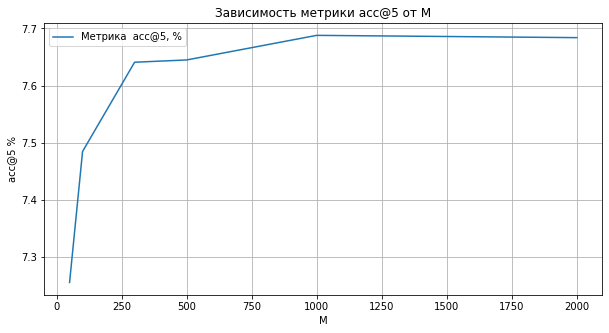

In [82]:
# график
(results_HNSWF
 .plot(y='Метрика  acc@5, %', 
       figsize=(10,5), title='Зависимость метрики acc@5 от M',
       xlabel='M', ylabel='acc@5 %',grid=True)
)
plt.show()

##### Вывод

Из графиков и вывода выше следует, что метрика упирается в потолок 7.7% в районе M=1000. Это хуже обычного `IndexFlatL2`, при этом время обучения и поиска примерно сопоставимо. Будем смотреть следующие индексы.

#### Индекс IndexIVFFlat

Рассмотрим `IndexIVFFlat`. Его параметры:
- quantizer - квантазер;
- d - размероность векторов;
- nlist - число кластеров;
- metric - метрика;

##### Инициализация и обучение

In [83]:
%%time

# параметры
d = df_arr.shape[1]
metric = faiss.METRIC_L2
nlists = [3, 5, 7, 9, 12, 15, 30, 50]
quantizer = faiss.IndexFlatL2(d)

# сюда будем добавлять результаты
result_acc_5 = {}

# инициализация
for n in tqdm(nlists):
    
    # время обучения старт
    start_faiss = perf_counter()
    # инициализация индекса
    IVFFlat = faiss.IndexIVFFlat(quantizer, d, n, metric)
    IVFFlat.nprobe = 8
    # обучение
    IVFFlat.train(df_arr)
    # добавление векторов в индекс
    IVFFlat.add(df_arr)
    # поиск в train
    # время обучения конец
    train_time = perf_counter() - start_faiss
    # поиск в train
    # время поиска старт
    start_faiss = perf_counter()
    _, I = IVFFlat.search(df_eval_arr, k=5)
    # время поиска конец
    search_time = perf_counter() - start_faiss
    # расчет метрики
    result_acc_5[n] = {'Метрика  acc@5, %': acc5_value(target_train, I, base_index),
                       'Время обучения, сек': train_time,
                       'Время поиска, сек': search_time,
                         }

# резульат запишем в датафрейм

results_IVFF = pd.DataFrame(result_acc_5).T

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [32:26<00:00, 243.34s/it]

Wall time: 32min 26s


##### Результат

In [92]:
results_IVFF.reset_index().rename(columns={'index':'nlist'}).style.format(precision=3)

,nlist,"Метрика acc@5, %","Время обучения, сек","Время поиска, сек"
0,3,7.866,0.361,315.720
1,5,7.866,0.136,330.935
2,7,7.866,0.161,337.505
3,9,7.866,0.144,326.281
4,12,7.854,0.150,256.721
5,15,7.845,0.141,204.827
6,30,7.784,0.162,109.115
7,50,7.742,0.205,61.861


##### График

Выведим график зависимости метрики `accuracy@5` от числа кластеров.

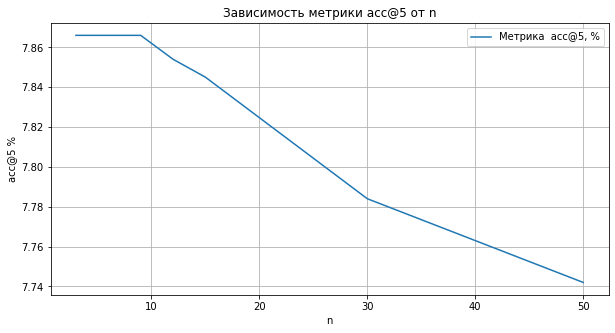

In [93]:
# график
(results_IVFF
 .plot(y='Метрика  acc@5, %', 
       figsize=(10,5), title='Зависимость метрики acc@5 от n',
       xlabel='n', ylabel='acc@5 %', grid=True)
)
plt.show()

##### Вывод

- Лучший результат достигается при малых значениях параметра `n` и равен 7.866%, однако при таких значениях сильно увеличивается время поиска. И это на 10% от базовой выборки, на 100% это будет еще дольше;
- Результат 7.866% не лучше результата, полученного при помощи `IndexFlatL2`.
- С увеличением числа кластеров метрика ухудшается, но  также снижается время поиска. Можно пожертоввать качеством ради скорости.
- При значениях `n` = 3, 5, 7 и 9 значение метрики acc@5 одинаковое. Время поиска +- схоже.

#### Индекс IndexLSH

Параметры:
- d - размероность векторов
- n_bits - число бит для каждого сохраненного вектора

#### Инициализация и обучение

In [94]:
%%time

# параметры 
d = df_rs.shape[1]
n_bits = 2 * d
# инициализация и обучение
lsh = faiss.IndexLSH(d, n_bits)
lsh.train(df_arr)
lsh.add(df_arr)

Wall time: 178 ms


##### Поиск

In [96]:
%%time

# поиск в train
_, I = lsh.search(df_eval_arr, k=5)

Wall time: 7.36 s


##### Результат

In [97]:
# метрика
result_lsh = acc5_value(target_train, I, base_index)
print(f'Значение метрики accuracy@5 = {result_lsh}%')

Значение метрики accuracy@5 = 7.483%


##### Вывод

- Время обучения + оценки результата составило - 7.5 секунд, что достаточно быстро;
- Однако значение метрики 7.483% для этого индекса хуже значений метрики для других индексов, рассмотренных ранее. Однако если важна скорость, то результат можно считать неплохим.

#### Индекс IndexScalarQuantizer

Параметры:
- d - размерность векторов
- qtype - тип квантайзера

##### Инициализация и обучение

In [98]:
%%time

# параметры 
d = df_rs.shape[1]
# инициализация и обучение
SQ = faiss.IndexScalarQuantizer(d, faiss.ScalarQuantizer.QT_8bit)
SQ.train(df_arr)
SQ.add(df_arr)

Wall time: 99.3 ms


##### Поиск

In [99]:
%%time

# поиск в train
_, I = SQ.search(df_eval_arr, k=5)

Wall time: 12min 57s


##### Результат

In [100]:
# метрика
result_SQ = acc5_value(target_train, I, base_index)
print(f'Значение метрики accuracy@5 = {result_SQ}%')

Значение метрики accuracy@5 = 7.871%


##### Вывод

- Долго обучается при том, что параметры не перебираются;
- Можно было бы перебирать второй параметр - тип квантайзера - 4bit, 6bit или 8bit.
- Но этот метод пока показал самый лучший результат - 7.871%, что выше 7.866%.

#### Индекс IndexPQ

Параметры:
- D - размерность векторов
- nbits - число бит, которые может использовать каждый субквантайзер
- m - число подвекторов (subvectors), для этого параметра должно выполняться D делится нацело на m;

##### Инициализация и обучение

In [101]:
%%time

D = df_rs.shape[1]
M = [k for k in range(2,D) if D%k==0]
nbits = 8  # number of bits per subquantizer, k* = 2**nbits

# сюда будем добавлять результаты
result_acc_5 = {}

# инициализация
for m in tqdm(M):

    # время обучения старт
    start_faiss = perf_counter()
    # инициализация индекса
    PQ = faiss.IndexPQ(D, m, nbits)
    # обучение
    PQ.train(df_arr)
    # добавление векторов в индекс
    PQ.add(df_arr)
    # поиск в train
    # время обучения конец
    train_time = perf_counter() - start_faiss
    # поиск в train
    # время поиска старт
    start_faiss = perf_counter()
    _, I = PQ.search(df_eval_arr, k=5)
    # время поиска конец
    search_time = perf_counter() - start_faiss
    # расчет метрики
    result_acc_5[m] = {'Метрика  acc@5, %': acc5_value(target_train, I, base_index),
                       'Время обучения, сек': train_time,
                       'Время поиска, сек': search_time,
                         }

# резульат запишем в датафрейм

results_PQ = pd.DataFrame(result_acc_5).T

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:34<00:00, 54.83s/it]

Wall time: 4min 34s


##### Результат

In [102]:
results_PQ.reset_index().rename(columns={'index':'m'}).style.format(precision=3)

,m,"Метрика acc@5, %","Время обучения, сек","Время поиска, сек"
0,2,2.334,2.372,14.177
1,4,5.543,3.970,10.129
2,8,7.287,6.440,28.281
3,16,7.758,12.724,51.152
4,32,7.861,23.153,120.207


##### График

Выведим график зависимости метрики `accuracy@5` от числа кластеров.

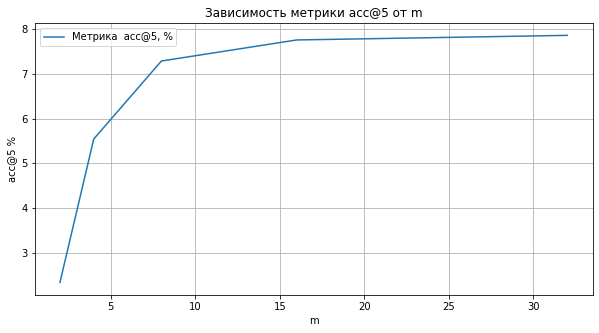

In [103]:
# график
(results_PQ
 .plot(y='Метрика  acc@5, %', 
       figsize=(10,5), title='Зависимость метрики acc@5 от m',
       xlabel='m', ylabel='acc@5 %', grid=True)
)
plt.show()

##### Вывод

- Показывает неплохие результаты - значение метрики 7.861%.
- Достиагется при самом высоком значении параметра `m`, при котором требуется больше времени на обучени и поиск;

#### Индекс IndexIVFScalarQuantizer

Параметры:
- quantizer - квантазер;
- d -размерность векторов;
- nlists - число кластеров;
- qtype - тип квантайзера;

##### Инициализация и обучение

In [104]:
%%time

# параметры
d = df_rs.shape[1]
nlists = [3, 5, 7, 9, 12, 15, 30, 50]
quantizer = faiss.IndexFlatL2(d)
qtype = faiss.ScalarQuantizer.QT_8bit

# сюда будем добавлять результаты
result_acc_5 = {}

# инициализация
for n in tqdm(nlists):

    # время обучения старт
    start_faiss = perf_counter()
    # инициализация индекса
    IVFSQ = faiss.IndexIVFScalarQuantizer(quantizer, d, n, qtype)
    IVFSQ.nprobe = 8
    # обучение
    IVFSQ.train(df_arr)
    # добавление векторов в индекс
    IVFSQ.add(df_arr)
    # поиск в train
    # время обучения конец
    train_time = perf_counter() - start_faiss
    # поиск в train
    # время поиска старт
    start_faiss = perf_counter()
    _, I = IVFSQ.search(df_eval_arr, k=5)
    # время поиска конец
    search_time = perf_counter() - start_faiss
    # расчет метрики
    result_acc_5[n] = {'Метрика  acc@5, %': acc5_value(target_train, I, base_index),
                       'Время обучения, сек': train_time,
                       'Время поиска, сек': search_time,
                         }

# резульат запишем в датафрейм

results_IVFSQ = pd.DataFrame(result_acc_5).T

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [1:13:59<00:00, 554.96s/it]

Wall time: 1h 13min 59s


##### Результат

In [106]:
results_IVFSQ.reset_index().rename(columns={'index':'n'}).style.format(precision=3)

,n,"Метрика acc@5, %","Время обучения, сек","Время поиска, сек"
0,3,7.866,0.420,752.593
1,5,7.867,0.176,760.519
2,7,7.867,0.178,772.775
3,9,7.870,0.194,726.616
4,12,7.858,0.170,573.736
5,15,7.847,0.179,458.123
6,30,7.788,0.195,248.772
7,50,7.742,0.232,142.548


##### График

Выведим график зависимости метрики `accuracy@5` от числа кластеров.

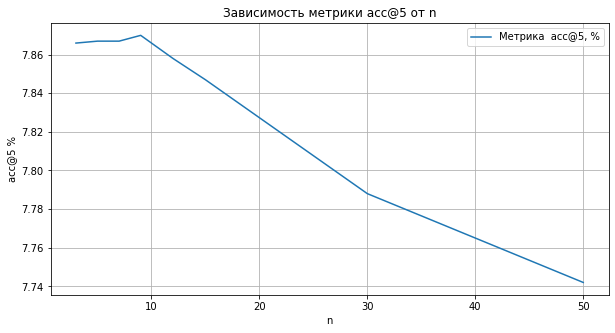

In [107]:
# график
(results_IVFSQ
 .plot(y='Метрика  acc@5, %', 
       figsize=(10,5), title='Зависимость метрики acc@5 от n',
       xlabel='n', ylabel='acc@5 %', grid=True)
)
plt.show()

##### Вывод

- Долгий поиск при параметрах, которые дают хороший результат - более 700 секунд -, и это при 10% от базовой выборки в индексе;
- Общее время перебора параметров составило 1 час 14 минут;
- Результаты оказались не сильно лучше IndexFlatL2 - 7.870% против 7.866%;

#### Индекс IndexIVFPQ

Параметры:
- coarse_quantizer - квантазер;
- ncentroids - число кластеров;
- D - размерность векторов
- nbits - число бит, которые может использовать каждый субквантайзер
- m - число подвекторов (subvectors), для этого параметра должно выполняться D делится нацело на m;

##### Инициализация и обучение

In [108]:
%%time

# параметры
D = df_rs.shape[1]
ncentroids = [3, 5, 7, 9, 12, 15, 30, 50]
coarse_quantizer = faiss.IndexFlatL2(d)
m = 32 # взято из результатов IndexPQ
nbits = 8

# сюда будем добавлять результаты
result_acc_5 = {}

# инициализация
for n in tqdm(ncentroids):
    
    # время обучения старт
    start_faiss = perf_counter()
    # инициализация индекса
    IVFPQ = faiss.IndexIVFPQ(coarse_quantizer, D, n, m, nbits)
    IVFPQ.nprobe = 8
    # обучение
    IVFPQ.train(df_arr)
    # добавление векторов в индекс
    IVFPQ.add(df_arr)
    # поиск в train
    # время обучения конец
    train_time = perf_counter() - start_faiss
    # поиск в train
    # время поиска старт
    start_faiss = perf_counter()
    _, I = IVFPQ.search(df_eval_arr, k=5)
    # время поиска конец
    search_time = perf_counter() - start_faiss
    # расчет метрики
    result_acc_5[n] = {'Метрика  acc@5, %': acc5_value(target_train, I, base_index),
                       'Время обучения, сек': train_time,
                       'Время поиска, сек': search_time,
                         }

# резульат запишем в датафрейм

results_IVFPQ = pd.DataFrame(result_acc_5).T

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [14:51<00:00, 111.44s/it]

Wall time: 14min 51s


##### Результат

In [109]:
results_IVFPQ.reset_index().rename(columns={'index':'n'}).style.format(precision=3)

,n,"Метрика acc@5, %","Время обучения, сек","Время поиска, сек"
0,3,7.864,22.825,117.928
1,5,7.877,21.781,121.244
2,7,7.856,22.038,120.922
3,9,7.857,22.065,117.723
4,12,7.851,22.119,93.100
5,15,7.836,22.169,74.949
6,30,7.778,22.337,41.570
7,50,7.744,22.251,24.168


##### График

Выведим график зависимости метрики `accuracy@5` от числа кластеров.

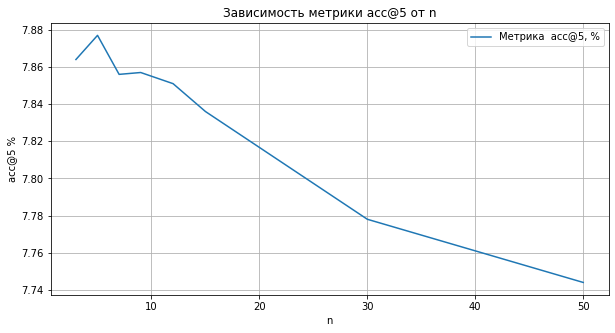

In [110]:
# график
(results_IVFPQ
 .plot(y='Метрика  acc@5, %', 
       figsize=(10,5), title='Зависимость метрики acc@5 от n',
       xlabel='n', ylabel='acc@5 %', grid=True)
)
plt.show()

##### Вывод

- На проверку 8 параметров затрачено 15 минут, что достаточно быстров сравнении с другими методами, где приходилось подбирать параметры;
- Получено лучшее значение метрики для 5 центройдов - значение равно 7.877%, что является лучшим значением из всех ранее рассмотренных вариантов;
- На обучение и поиск было затрачено 143 секунды;

<b>С учетом скорости и качества будет выбран этот алгоритм. Отдельно рассмотрим значение ncentroids = 4 и 6. Возможно, получится чуть улучшить результат</b>

### Проверка алгоритма на тесте:

#### Подготовка датасетов (стандартизация, перевод в формат `FAISS`)

In [111]:
%%time

# стандартизация с помощью RobustScaler
RobScaler = RobustScaler().fit(df_base_t)
# базовый стандартизированный датасет
df_base_rs = pd.DataFrame(RobScaler.transform(df_base_t), 
                          index=df_base_t.index, 
                          columns=df_base_t.columns)
# тестовый датасет
df_validation_t_rs = pd.DataFrame(RobScaler.transform(df_validation_t), 
                                                      index=df_validation_t.index, 
                                                      columns=df_validation_t.columns)

# базовый индекс 
base_index = {k: v for k, v in enumerate(df_base_rs.index.to_list())}
# преобразование датасетов в ascontiguousarray
df_arr = np.ascontiguousarray(df_base_rs.values).astype('float32')
df_eval_arr = np.ascontiguousarray(df_validation_t_rs.values).astype('float32')

Wall time: 18.6 s


#### Обучение

In [112]:
%%time

# параметры
D = df_arr.shape[1]
ncentroids = 5
coarse_quantizer = faiss.IndexFlatL2(D)
m = 32 # взято из результатов IndexPQ
nbits = 8

# инициализация модели
final_model = faiss.IndexIVFPQ(coarse_quantizer, D, ncentroids, m, nbits)
final_model.nprobe = 8
# обучение
final_model.train(df_arr)
final_model.add(df_arr)

Wall time: 43.7 s


#### Проверка на тестовой выборке

In [113]:
%%time

# поиск в validation
_, I = final_model.search(df_eval_arr, k=5)
# расчет метрики
result_valid = acc5_value(df_valid_answ.squeeze(), I, base_index)

Wall time: 20min 18s


#### Результат

In [115]:
print(f'Значение метрики accuracy@5 = {result_valid}%')

Значение метрики accuracy@5 = 70.852%


### Вывод

<ins>Результат</ins>: подобран алгоритм, который достига значения метрики `accuracy@5` = 70.852%, что чуть выше исходных 70.4%.<br>
<ins>Алгоритм</ins>: по результатам исследования был выбран индекс `IndexIVFPQ` с параметрами:
- D = 62;
- ncentroids = 5;
- квантайзер - `IndexFlatL2`;
- m = 32;
- nbits = 8;

<ins>Данные</ins>: индекс обучен на полных данных `base.csv` и протестирован на `validation.csv`.

<ins>Обработка исходных данных</ins>: 
- удалены признаки, распределение которых отличается от нормального;
- значения признаков стандартизированы методом `RobustScaler`;

<ins>Параметры обучения и поиска</ins>:
- время обучения - 43,7 секунд;
- время поиска - 20 минут 18 секунд;